In [159]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [160]:
df=pd.read_csv('test_scores.csv')
df.head()

,school,school_setting,school_type,classroom,teaching_method,n_student,student_id,gender,lunch,pretest,posttest
0,ANKYI,Urban,Non-public,6OL,Standard,20.0,2FHT3,Female,Does not qualify,62.0,72.0
1,ANKYI,Urban,Non-public,6OL,Standard,20.0,3JIVH,Female,Does not qualify,66.0,79.0
2,ANKYI,Urban,Non-public,6OL,Standard,20.0,3XOWE,Male,Does not qualify,64.0,76.0
3,ANKYI,Urban,Non-public,6OL,Standard,20.0,556O0,Female,Does not qualify,61.0,77.0
4,ANKYI,Urban,Non-public,6OL,Standard,20.0,74LOE,Male,Does not qualify,64.0,76.0


## Problem Framming

- Business objective apa yang hendak dicapai melalui proyek ini?
     Memprediksi apa yang mempengaruhi hasil Posttest dari siswa
- Keluaran (output) seperti apa yang akan dihasilkan dari proyek ini dan bagaimana end user atau stakeholder akan memanfaatkan keluaran tersebut?
    Nilai posttest yang di prediksi
- Machine learning task apa yang akan dikerjakan? (supervised/unsupervised learning, classification/regression/clustering/dimensionality reduction problem dsb.)
    Supervised dengan regression
- Performance measure apa yang akan digunakan di dalam proyek ini? 
- Risiko seperti apa yang mungkin diakibatkan oleh kesalahan prediksi dari model Anda?


## EDA

In [161]:
df.isnull().sum()

school             0
school_setting     0
school_type        0
classroom          0
teaching_method    0
n_student          0
student_id         0
gender             0
lunch              0
pretest            0
posttest           0
dtype: int64

tidak terdapat missing value

In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2133 entries, 0 to 2132
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   school           2133 non-null   object 
 1   school_setting   2133 non-null   object 
 2   school_type      2133 non-null   object 
 3   classroom        2133 non-null   object 
 4   teaching_method  2133 non-null   object 
 5   n_student        2133 non-null   float64
 6   student_id       2133 non-null   object 
 7   gender           2133 non-null   object 
 8   lunch            2133 non-null   object 
 9   pretest          2133 non-null   float64
 10  posttest         2133 non-null   float64
dtypes: float64(3), object(8)
memory usage: 183.4+ KB


In [163]:
#numerical attributes
numeric_columns=df.select_dtypes(include=['number']).columns.tolist()

#categorical attributes
cat_columns=df.select_dtypes(exclude=['number','bool_']).columns.tolist()

In [164]:
numeric_columns

['n_student', 'pretest', 'posttest']

memisahkan numerical dan categorical

In [165]:
df['school'].value_counts()

GOOBU    158
QOQTS    149
UKPGS    128
DNQDD    122
GJJHK    118
ZOWMK    117
VVTVA    114
KZKKE    111
CCAAW    109
CUQAM    107
VKWQH    100
IDGFP     94
UAGPU     87
UUUQX     84
OJOBU     81
CIMBB     74
ZMNYA     69
GOKXL     64
LAYPA     57
KFZMY     52
VHDHF     51
FBUMG     46
ANKYI     41
Name: school, dtype: int64

melihat seberapa banyak siswa di setiap sekolah yang ada pada data ini

<AxesSubplot:>

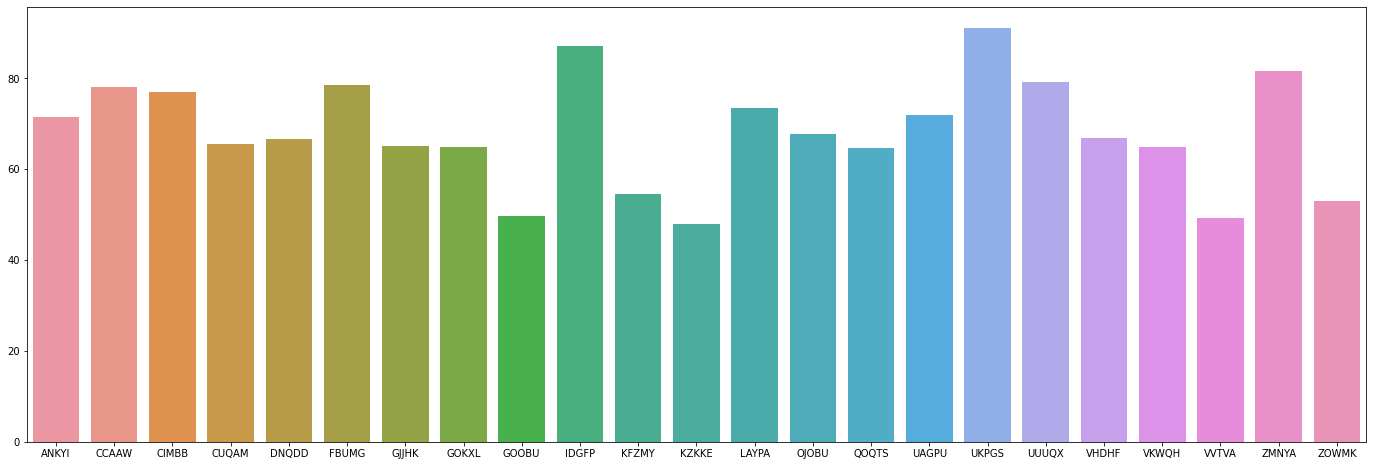

In [166]:
scores = df.groupby('school')['posttest'].mean()
plt.figure(figsize=(24,8))
sns.barplot(x=df['school'].unique(), y=scores.values)

Rata rata Posttest setiap sekolah

Siswa paling sedikit di sekolah ANKYI adalah 41 siswa dan saya rasa sekolah juga memiliki faktor terhadap prediksi posttest. Maka dari itu, nantinya akan dilakukan One Hot Encoding

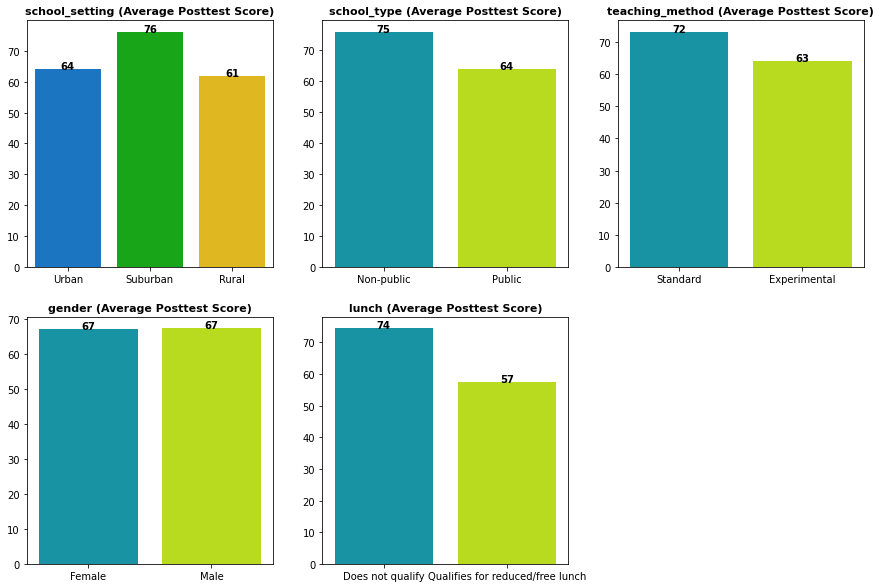

In [167]:
fig, ax = plt.subplots(2,3,figsize=(15,10))

def graph(x, i):
    sns.barplot(x=df[x].unique(), y=df.groupby(x)['posttest'].mean().values, ax=i, palette='nipy_spectral')
    i.set_title(x+' (Average Posttest Score)', fontsize=11, fontdict={"fontweight": "bold"})
    
    for p in i.patches:
        text = str(int(p.get_height()))
        i.annotate(text, (p.get_x()+p.get_width()/2, p.get_height()+1),
                   ha="center", va='center', fontsize=10, fontweight="bold")

graph('school_setting', ax[0,0])
graph('school_type', ax[0,1])
graph('teaching_method', ax[0,2])
graph('gender', ax[1,0])
graph('lunch', ax[1,1])
fig.delaxes(ax= ax[1,2]) 

Pada grafik diatas ditunjukan terdapat perbedaan rata-rata disetiap grouping (kecuali gender). jadi saya memutuskan akan memakai fitur fitur tersebut pada modeling

## Data Preprocessing

Preprocessing data dilakukan dengan menggunakan fungsi berikut:

- StandardScaling: standarisasi data numerik agar skala yang sama. Digunakan RobustScaler karena data distribusinya skewed dan punya banyak outlier
- BinaryEncoding: membuat fitur year dan engineSize ke dalam bentuk ordinal
- LabelEncoder: membuat fitur kategori menjadi numerik

In [168]:
X = df.drop(['student_id', 'gender', 'posttest','classroom'], axis=1)
y = df['posttest']
display(X.head())
display(y.head())

,school,school_setting,school_type,teaching_method,n_student,lunch,pretest
0,ANKYI,Urban,Non-public,Standard,20.0,Does not qualify,62.0
1,ANKYI,Urban,Non-public,Standard,20.0,Does not qualify,66.0
2,ANKYI,Urban,Non-public,Standard,20.0,Does not qualify,64.0
3,ANKYI,Urban,Non-public,Standard,20.0,Does not qualify,61.0
4,ANKYI,Urban,Non-public,Standard,20.0,Does not qualify,64.0


0    72.0
1    79.0
2    76.0
3    77.0
4    76.0
Name: posttest, dtype: float64

In [169]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer
scaled_cols = ['n_student', 'pretest']
binary_cols = ['school_setting', 'school_type', 'teaching_method', 'lunch']
label_cols = ['school']

scaler = StandardScaler()
label_encoder = LabelEncoder()
binary_encoder = LabelBinarizer()

for x in binary_cols:
    a = binary_encoder.fit_transform(X[x])
    X[x] = a
for col in label_cols:
    a = label_encoder.fit_transform(X[col])
    X[col]=a

In [170]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Model Training

Model yang akan digunakan:
-LogisticRegression
-KNeighborsRegressor
-DecisionTreeRegressor

In [171]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, roc_curve, roc_auc_score, r2_score, mean_squared_error
from sklearn import metrics

In [172]:
model1 = LogisticRegression(max_iter=1000)
model1.fit(X_train, y_train)
pred1 = model1.predict(X_test)
acc1 = r2_score(y_test, pred1)
mae1 = mean_absolute_error(y_test, pred1)
mse1 = mean_squared_error(y_test, pred1)
print('Accuracy: {:.2f} \nMAE: {:.2f} \nMSE: {:.2f}'.format(acc1*100, mae1, mse1))

Accuracy: 84.19 
MAE: 4.18 
MSE: 30.60
C:\Users\Rayhan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [173]:
model2 = KNeighborsRegressor()
model2.fit(X_train, y_train)
pred2 = model2.predict(X_test)
acc2 = r2_score(y_test, pred2)
mae2 = mean_absolute_error(y_test, pred2)
mse2 = mean_squared_error(y_test, pred2)
print('Accuracy: {:.2f} \nMAE: {:.2f} \nMSE: {:.2f}'.format(acc2*100, mae2, mse2))

Accuracy: 93.27 
MAE: 2.84 
MSE: 13.01


In [174]:
model3= SVC()
model3.fit(X_train, y_train)
pred3 = model3.predict(X_test)
acc3 = r2_score(y_test, pred3)
mae3 = mean_absolute_error(y_test, pred3)
mse3 = mean_squared_error(y_test, pred3)
print('Accuracy: {:.2f} \nMAE: {:.2f} \nMSE: {:.2f}'.format(acc3*100, mae3, mse3))

Accuracy: 83.75 
MAE: 4.52 
MSE: 31.44


In [175]:
acc_table = pd.DataFrame({'Model': ['Logistic Regression',
                                   'KNN',
                                   'SVC'],
                         'Accuracy Score': [acc1,
                                           acc2,
                                           acc3
                                           ]})
acc_table = acc_table.sort_values(by='Accuracy Score', ascending=False)
acc_table.style.background_gradient()

,Model,Accuracy Score
1,KNN,0.932746
0,Logistic Regression,0.841858
2,SVC,0.837506


In [176]:
error_table = pd.DataFrame({'Model': ['Logistic Regression',
                                   'KNN',
                                   'SVC'
                                   ],
                         'MSE': [mse1,
                                           mse2,
                                           mse3],
                           'MAE': [mae1,
                                           mae2,
                                           mae3]})
error_table = error_table.sort_values(by='MSE', ascending=True)
error_table.style.background_gradient(cmap='Blues')

,Model,MSE,MAE
1,KNN,13.012062,2.843438
0,Logistic Regression,30.596875,4.181250
2,SVC,31.439062,4.520313


## Evaluation, Model Selection, and Model Tuning

In [177]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV


cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

knn = KNeighborsRegressor()

space = dict()
space['n_neighbors'] = [4,5,6,7,8,10]
space['weights'] = ['uniform', 'distance']
space['leaf_size'] = [10,20,30,40,50]
space['algorithm'] = ['auto', 'ball_tree', 'kd_tree', 'brute']

search = GridSearchCV(knn, space, scoring='r2', n_jobs=-1, cv=cv)
result = search.fit(X_train,y_train)
print('Best Score: %s' %result.best_score_)
print('Best HyperParameters: %s' %result.best_params_)

C:\Users\Rayhan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Rayhan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Rayhan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
Best Score: 0.9375724820338651
Best HyperParameters: {'algorithm': 'brute', 'leaf_size': 10, 'n_neighbors': 5, 'weights': 'uniform'}


In [178]:
t_model = KNeighborsRegressor(leaf_size=45, n_neighbors=8, n_jobs=-1, p=1)
t_model.fit(X_train, y_train)
t_pred = t_model.predict(X_test)
t_acc = r2_score(y_test, t_pred)
t_mae = mean_absolute_error(y_test, t_pred)
t_mse = mean_squared_error(y_test, t_pred)
print('Accuracy: {:.2f} \nMAE: {:.2f} \nMSE: {:.2f}'.format(t_acc*100, t_mae, t_mse))
print('Improvement \nAcc: {:.2f} \nMAE: {:.2f} \nMSE: {:.2f}'.format(t_acc*100-acc3*100, t_mae - mae3, t_mse - mse3))

Accuracy: 94.09 
MAE: 2.70 
MSE: 11.43
Improvement 
Acc: 10.34 
MAE: -1.82 
MSE: -20.01


Best Model Parameter Tuning (KNN)
By changing parameters with the best parameters I got from the GridSearchCV, my model did not improve so I decided to change parameters on my own just in case

## Result, Conclusion, and Recommendation



In [179]:
jadi kesimpulannya, model terbaik yang digunakan untuk memprediksi hasil dari posttest adalah KNN (berdasarkan hasil model training diatas)
Yang mempengaruhi hasil posttest hampir seluruh variable berdasarkan analisa diatas.

SyntaxError: invalid syntax (<ipython-input-179-9cdaa6aa9ba5>, line 1)